In [1]:
from enc import ctoi
from collections import Counter, defaultdict
from itertools import combinations
import math

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import scipy as sp

In [2]:
def stream_diff(s1, s2):
    ds = s1 - s2
    for i, d in enumerate(ds):
        if d < 0:
            ds[i] += 27
    return ds

def cntr_entropy(counter: Counter):
    ent = 0.
    for cnt in counter.values():
        p = cnt / sum(counter.values())
        ent -= p * math.log(p)
    return ent

def entropy(data):
    if isinstance(data, Counter):
        return cntr_entropy(data)

    _, counts = np.unique(data, return_counts=True)
    probs= counts / counts.sum()
    ent = -np.sum(probs * np.log(probs))
    return ent

def encode(text):
    return np.array([ctoi[c] for c in text])

In [3]:
keys = range(4, 25)

def load_ciphers():
    ciphers = defaultdict(list)
    for key_len in keys:
        for correct in range(1, 6):
            filename = f'resources/key_{key_len}/cipher_{correct}'
            with open(filename, 'r') as f:
                ciphers[key_len].append(f.readline().strip())
    return ciphers

plains = [
    "barmiest hastes spades fevers cause wisped unconquerable tropical pythagoras rebukingly price ephedra overdecorates linked smitten trickle scanning cognize oaken casework politicize significate influenceable precontrived clockers defalcation workwomen splintery kids placidness harebrained liberalism neuronic clavierist attendees matinees prospectively bubbies longitudinal raving relaxants rigged oxygens chronologist briniest tweezes profaning abeyances fixity gulls coquetted budgerigar drooled unassertive shelter subsoiling surmounted underwear jobbed hobnailed fulfilling jaywalking testabilit",
    "denunciation chronaxy imperilment incurred defrosted protectorates committeemen refractory narcissus bridlers weathercocks occluding orchectomy syncoms beamy opticopupillary acculturation scouting headstrong tosh preconscious weekday reich saddler mercerizes saucepan bifold regenerate chit reviewable easiness brazed essentially idler dependable predicable locales rededicated cowbird kvetched confusingly airdrops dreggier privileges tempter anaerobes glistened sartorial distrustfulness papillary ughs proctoring duplexed pitas traitorously unlighted cryptographer odysseys metamer either meliorat",
    "trenched wickerwork orientation candidnesses nets opalescing pharynxes recompensive incomes shoes porcine pursue blabbered irritable ballets grabbed scything oscillogram despots disarraying curiousest crappier friending wining cypher insubmissive oceanid bowlegs voider recook parochial trop gravidly vomiting hurray friended uncontestable situate fen cyclecars gads macrocosms dhyana overruns impolite europe cynical jennet tumor noddy canted clarion opiner incurring knobbed planeload megohm dejecting campily dedicational invaluable praecoces coalescence dibbuk bustles flay acuities centimeters l",
    "angle obliquely bean mariachi walkup toilettes squib tightwads pipe extents rejoicing nectar asker dreadfuls kidnappers interstate incrusting quintessential neglecter copycat phosphatic streakier frowning phantasmagories supinates imbibers inactivates tingly deserter steerages beggared pulsator laity salvageable bestrode interning stodgily cracker excisions quanted arranges poultries sleds shortly packages apparat fledge alderwomen halvah verdi ineffectualness entrenches franchising merchantability trisaccharide limekiln sportsmanship lassitudes recidivistic locating iou wardress estrus potboi",
    "schmeering institutor hairlocks speeder composers dramatics eyeholes progressives headmaster attractant subjugator peddlery vigil dogfights pixyish comforts aretes brewage felinities salerooms reminiscent hermaphrodism simultaneous spondaics hayfork armory refashioning battering darning tapper pancaked unaffected televiewer mussiness pollbook sieved reclines restamp cohosh excludes homelier coacts refashioned loiterer prospectively encouragers biggest pasters modernity governorships crusted buttoned wallpapered enamors supervisal nervily groaning disembody communion embosoming tattles turbans ",
]
    
ciphers = load_ciphers()

In [4]:
# Entropy Start Point Analysis
# The first N characters are used to compute the entropy of diff streams
# If one of the streams shows an anomaly, we conclude that the plaintext, which the stream came from
# is the one we are looking for.

def plot_start_entropy(N=30, threshold=0.186):
    fig, axes = plt.subplots(21, 5, figsize=(20, 30))
    working_cases = 0
    correct_cases = 0
    wrong_cases   = 0
    stds = []
    for key in keys:
        ax_row = axes[key-4]
        stds = []
        for ci, ciphertext in enumerate(ciphers[key]):
            ax = ax_row[ci]
            
            ents = []
            # Compute entropies of each (cipher - plain) array
            for pi, plaintext in enumerate(plains, 1):
                plain_stream = encode(plaintext[:N])
                cipher_stream = encode(ciphertext[:N])
                diff_stream = stream_diff(cipher_stream, plain_stream)
                ent = entropy(diff_stream)
                ents.append(ent)
            
            min_ent_i = np.argmin(ents)

            ent_avg = np.mean(ents)
            ent_std = np.std(ents)
            stds.append(ent_std)

            ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
            ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
            ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
            
            for pi, ent in enumerate(ents):
                if pi == min_ent_i and ent_std > threshold:
                    ax.bar(pi, ent, color='red', width=0.5, label=f'plain_{pi+1}')
                    if pi == ci:
                        ax.set_facecolor('xkcd:seafoam')
                        correct_cases += 1
                    else:
                        ax.set_facecolor('xkcd:salmon')
                        wrong_cases += 1
                else:
                    ax.bar(pi, ent, color='blue', width=0.5, label=f'plain_{pi+1}')

            ax.set_ylim(ent_avg - 3 * ent_std, ent_avg + 5 * ent_std)
            if ent_std > threshold:
                working_cases += 1
            ax.set_title(f'key_lenth={key}, cipher {ci+1} ({ent_std:.4f})')
        
    print('total=', 5 * 21)
    print('working=', working_cases)
    print('correct=', correct_cases)
    print('wrong=', wrong_cases)
    print('working rate=', working_cases / (5 * 21) * 100)
    print('true positive rate=', correct_cases / working_cases * 100)
    print('false positive rate=', wrong_cases / working_cases * 100)
    print(np.mean(stds), np.std(stds))
    
    fig.tight_layout()
    plt.show()

## Strategy 1: Start Point Entropy Analysis

1. Measure difference between the cipher stream and each plain stream, for the first N characters.
2. Calculate the entropy of the difference
3. If the standard deviation of entropies to plain streams is observed to be high, then the plain stream, of which the entropy being the minimum, is highly likely to be the decrypted plain stream.

* The threshold of standard deviation varies with a choice of N. Since, if N is set largely, then each entropy would be more prone to be observed to be high, since there would be more random characeters inserted.
* The good values of N and threshold are determined impiirically. Two candidates are (N=30, threshold=0.186) and (N=60, threshold=0.11). The former one is observed to work for more cases. And smaller N is considered to be more effective for cases where key lengths are short. Therefore, to be more accurate for specific cases (short key lengths), we choose N=30 and threshold=0.186.

total= 105
working= 16
correct= 16
wrong= 0
working rate= 15.238095238095239
true positive rate= 100.0
false positive rate= 0.0
0.08482660058958405 0.028956381235011996


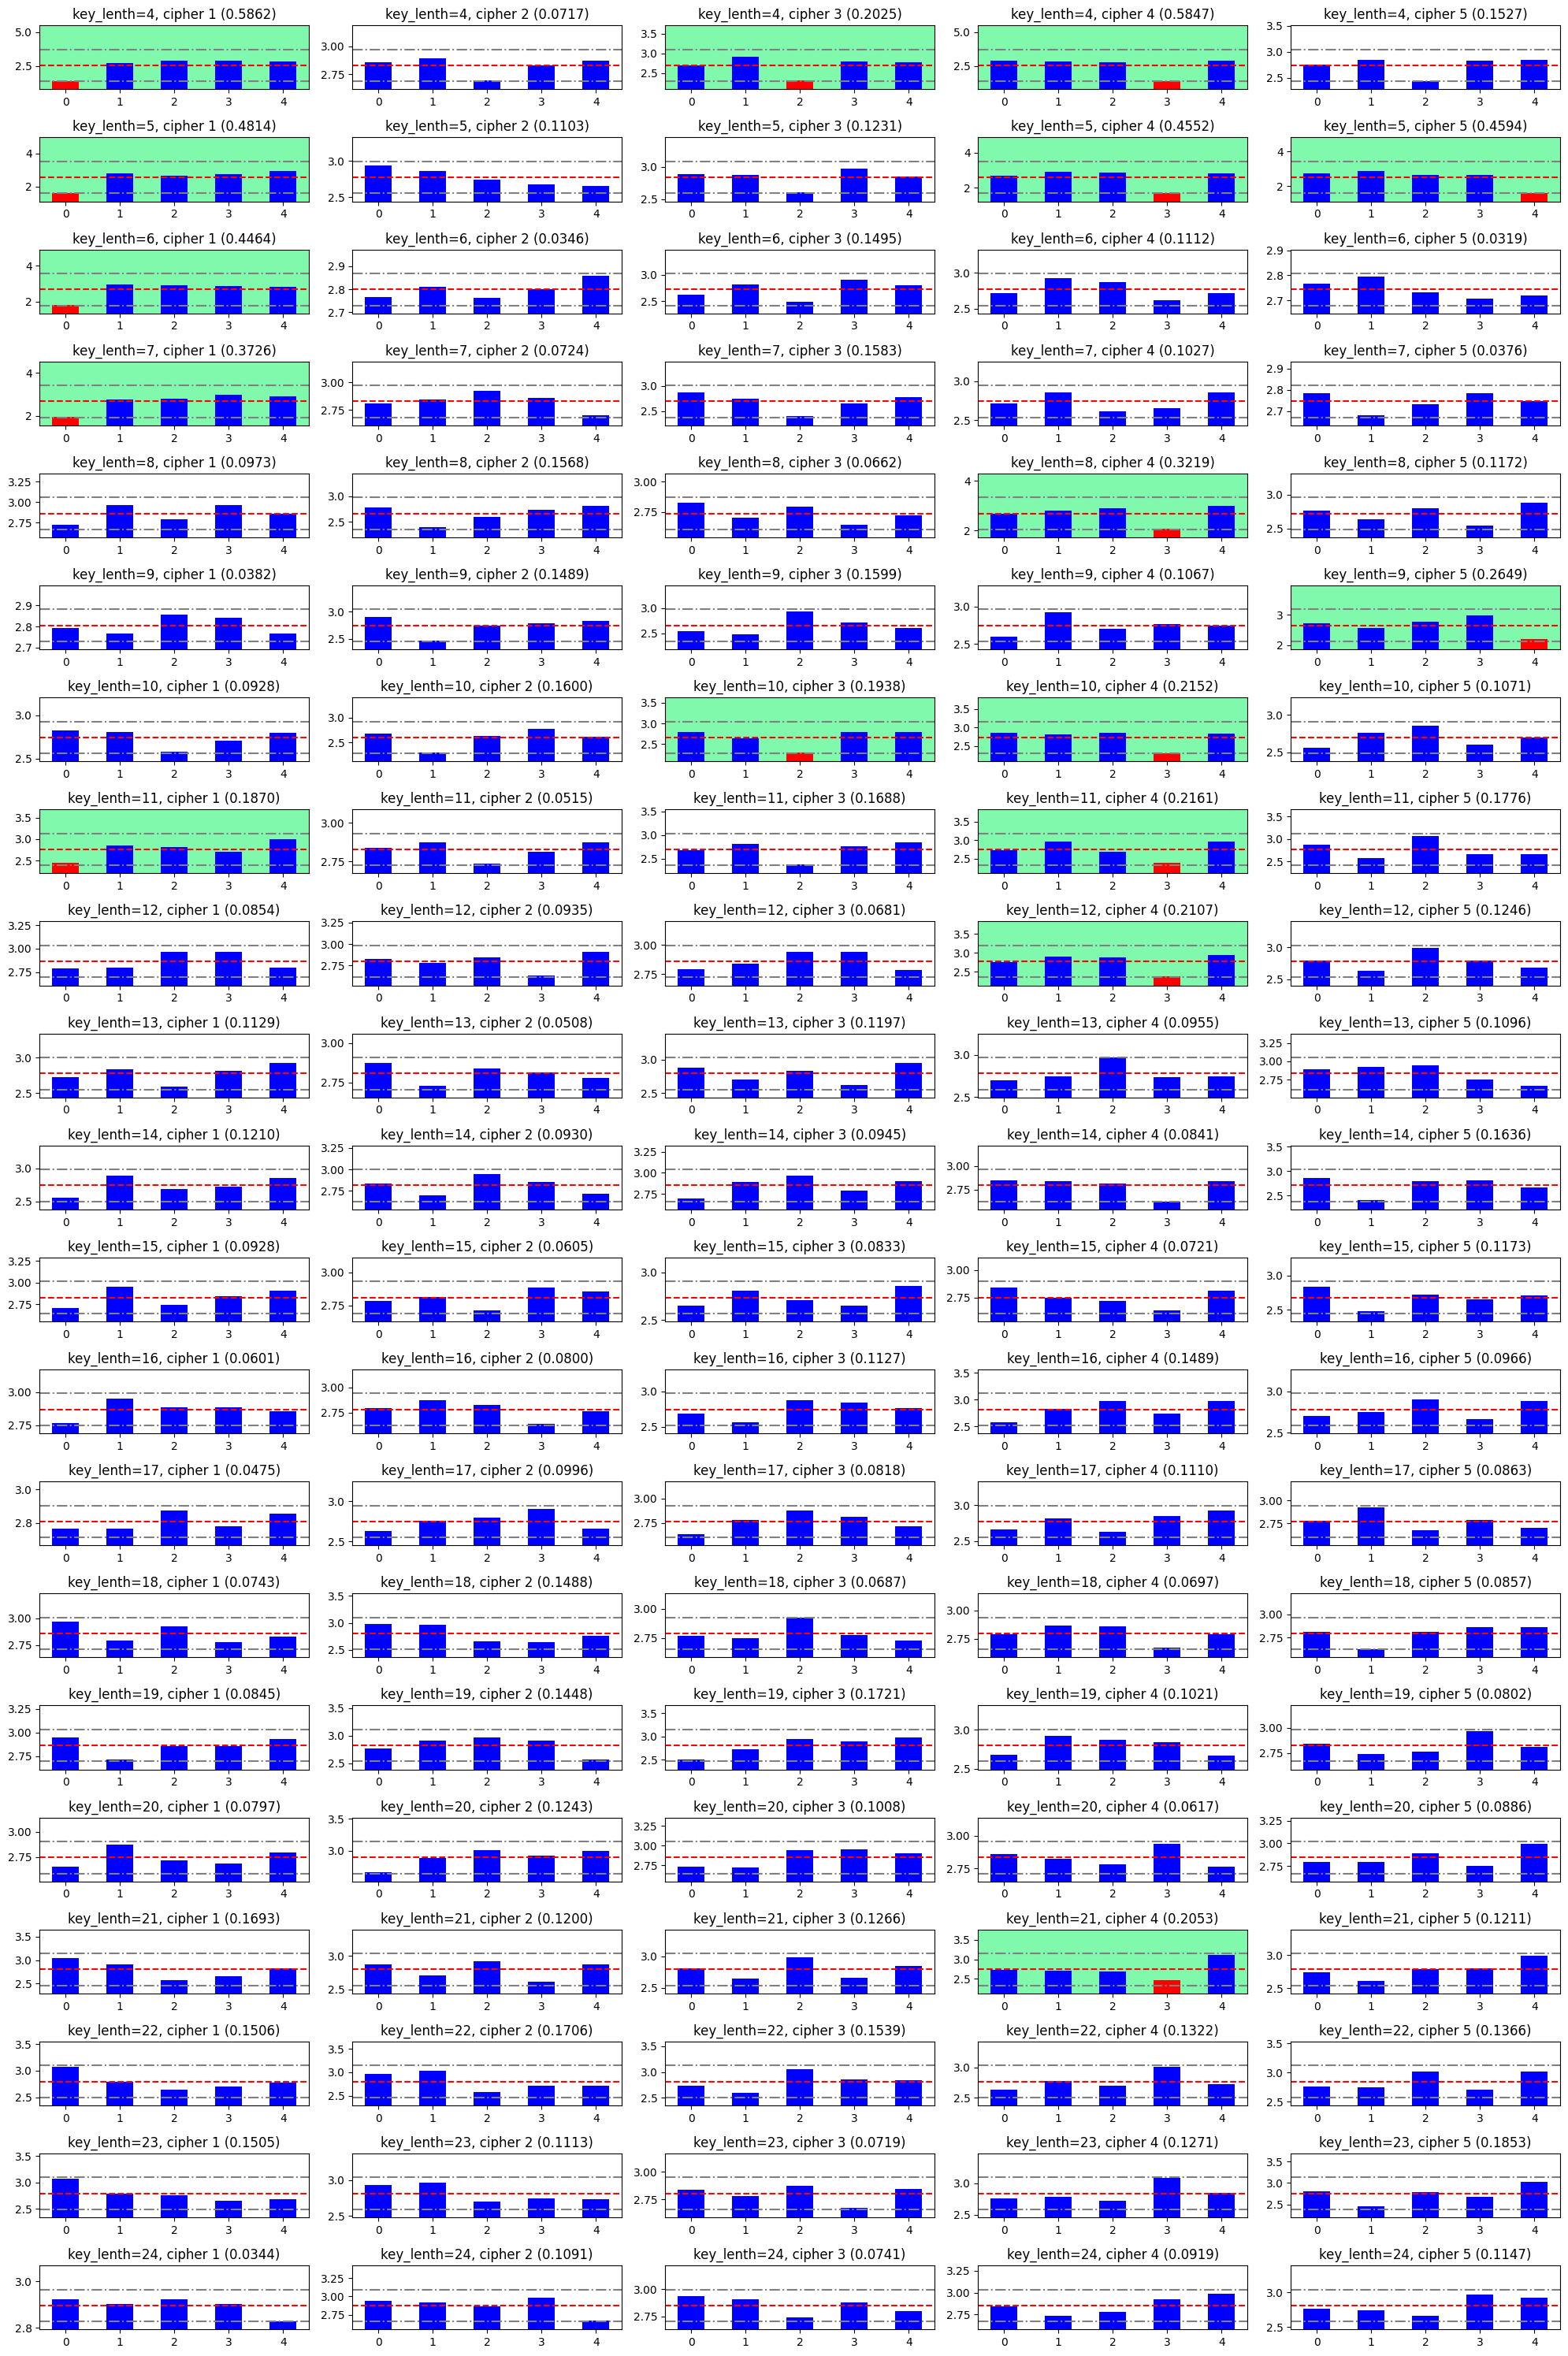

In [5]:
# The threshold value is picked empirically
plot_start_entropy(30, 0.186)

total= 105
working= 11
correct= 11
wrong= 0
working rate= 10.476190476190476
true positive rate= 100.0
false positive rate= 0.0
0.05902752582730575 0.02242716427374797


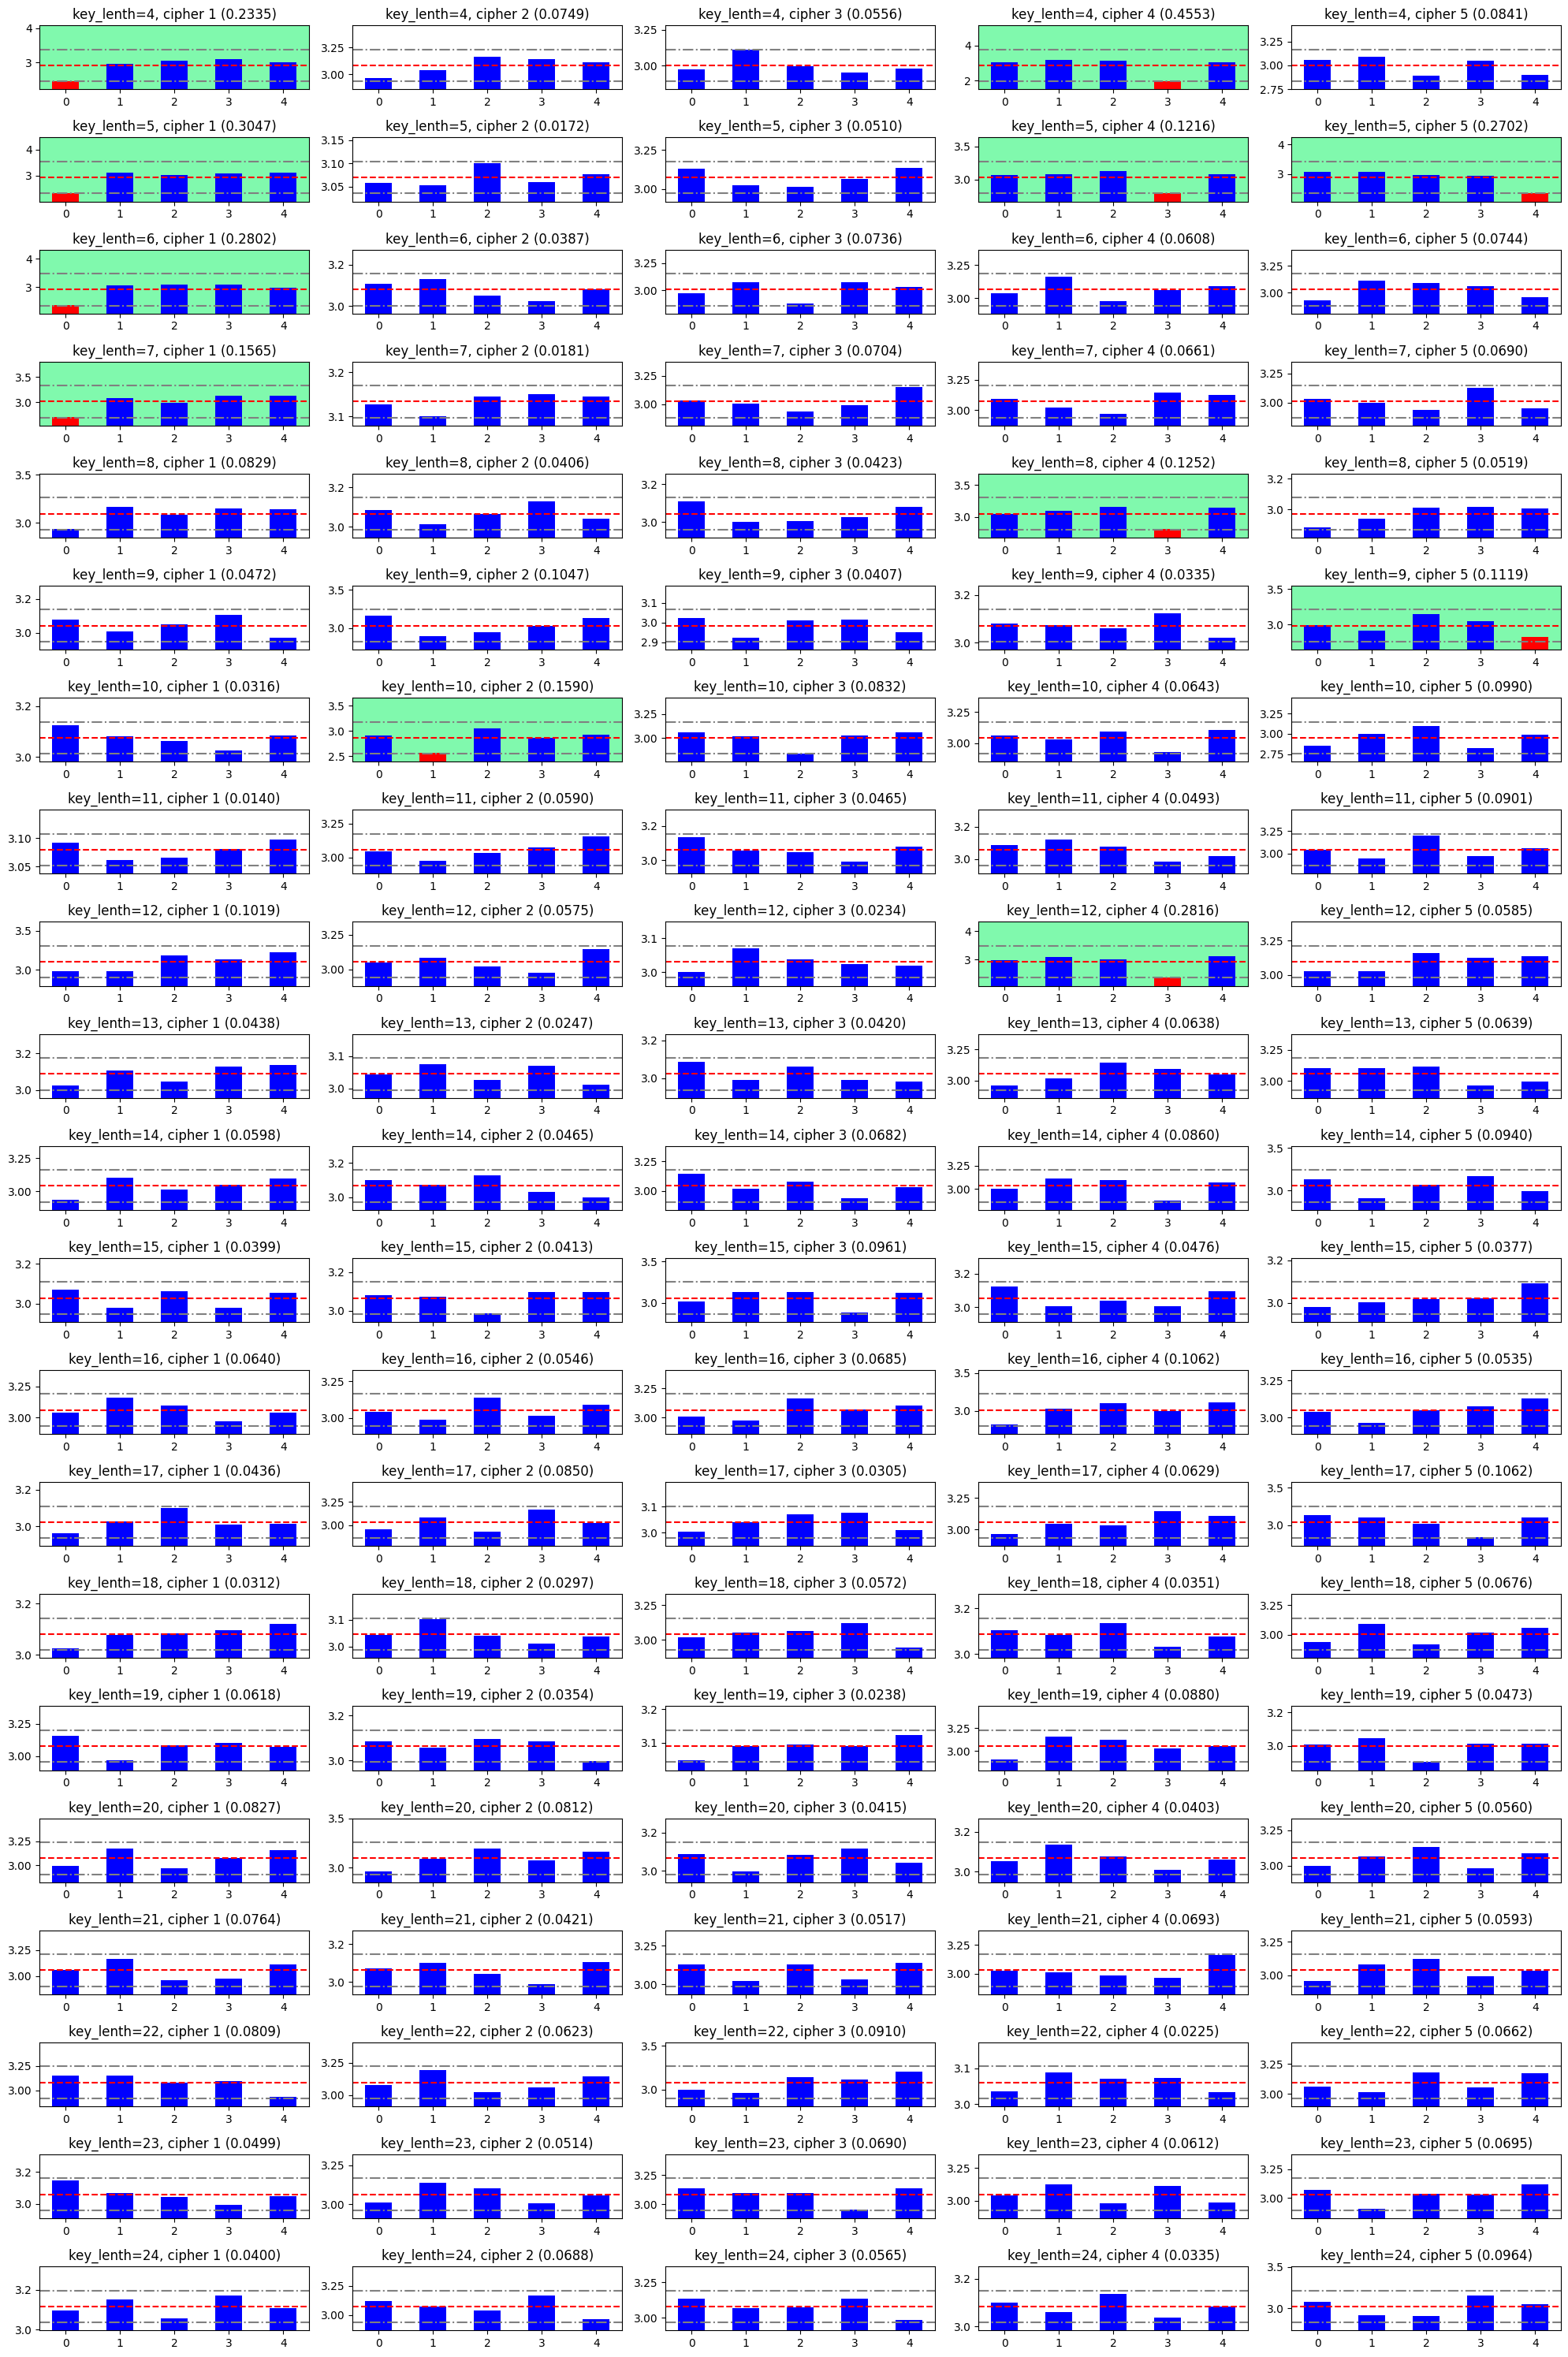

In [6]:
plot_start_entropy(60, 0.11)

In [7]:
def cipher_removed_at(ciphertext, i):
    return ciphertext[:i] + ciphertext[i+1:]

def print_list(list):
    for i in list:
        print('%02d' % i, end=' ')
    print()

# Optimize the input ciphertext to match the plaintext,
# using entropy change within the searchspace
# Return the range of the ciphertext that could be removed to reduce the entropy
def select_first_local_minimum_removal(ciphertext, plaintext, search_space=30) -> range:

    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)
    start_ent = entropy(diffs)

    prev_ent = start_ent

    first_new_ciphertext = ciphertext[1:][:search_space]
    first_new_cipher_stream = encode(first_new_ciphertext)
    diffs = stream_diff(first_new_cipher_stream, plain_stream)
    first_ent = entropy(diffs)

    allow_increasing = first_ent > start_ent * 1.02

    ci = 0
    ents = []
    de_list = [] # delta(entropy)
    while ci < search_space:
        new_ciphertext = cipher_removed_at(ciphertext, ci)
        new_cipher_stream = encode(new_ciphertext[:search_space])
        plain_stream = encode(plaintext[:search_space])
        diffs = stream_diff(new_cipher_stream, plain_stream)
        ent = entropy(diffs)
        ents.append(ent)

        de = (ent - prev_ent) / prev_ent * 100
        de_list.append(de)

        if de > 1.2 and not allow_increasing:
            return range(max(0, ci-4), min(search_space, ci + 1))
        if de < 0:
            allow_increasing = False

        ci += 1
        prev_ent = ent
    
    return range(0)


In [8]:
def plot_diffs_fft(diffs, ax=None):
    freqs = np.fft.fft(diffs)
    mags = np.abs(freqs)
    # Plot only positive frequencies
    mags = mags[:len(mags)//2]
    zeros = np.where(mags == 0)[0]

    if ax:
        ax.stem(mags)  
        ax.set_title(f'{len(zeros)}\n{diffs}')

        if len(zeros) >= 1:
            ax.set_facecolor('xkcd:seafoam')
        # ax.set_xlabel('Frequency')
        # ax.set_ylabel('Magnitude')
        # ax.set_title('FFT of Data')
        

def search_fft_fit(ciphertext, plaintext, removal_candids, search_space=30, axes=None):
    # print('candidates', list(removal_candids))
    plot = axes is not None and len(axes) > 0
    for ss in range(8, search_space):
        if plot:
            ax_row = axes[ss-8]
        for i, ci in enumerate(removal_candids):
            if plot:
                if hasattr(ax_row, '__getitem__'):
                    ax = ax_row[i]
                else:
                    ax = ax_row
            new_ciphertext = cipher_removed_at(ciphertext, ci)
            cipher_stream = encode(new_ciphertext[:ss])
            plain_stream = encode(plaintext[:ss])
            diffs = stream_diff(cipher_stream, plain_stream)
            if plot:
                plot_diffs_fft(diffs, ax=ax)

            freqs = np.fft.fft(diffs)
            mags = np.abs(freqs)
            mags = mags[:len(mags)//2]
            zeros = np.where(mags == 0)[0]

            if len(zeros) >= 1:
                # print(len(zeros), diffs)
                return ss, ci
    
    return -1, None

In [15]:
def detect_start_entropy_anomaly(ciphertext, N=30, threshold=0.186, ax=None, pick_min=False):
    cipher_stream = encode(ciphertext[:N])

    ents = []

    for pi, plaintext in enumerate(plains):
        plain_stream = encode(plaintext[:N])
        diffs = stream_diff(cipher_stream, plain_stream)
        ent = entropy(diffs)
        ents.append(ent)
    
    if ax:
        ax.bar(range(1, 6), ents, width=0.5)
        ent_avg = np.mean(ents)
        ent_std = np.std(ents)

        ax.set_ylim(ent_avg - 5 * ent_std, ent_avg + 3 * ent_std)

        ax.set_title(f'std={ent_std:.4f}')
        ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
        ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
        ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
    
    if pick_min:
        return np.argmin(ents)
    
    if np.std(ents) > threshold:
        return np.argmin(ents)

    return -1


def try_remove_one_random_char(ciphertext):
    for pi, plaintext in enumerate(plains):
        candids = select_first_local_minimum_removal(ciphertext, plaintext)
        l, remove_i = search_fft_fit(ciphertext, plaintext, candids)

        # optimization success
        if l != -1:
            return pi
    
    return -1


def decrypt_1(ciphertext, N=30, threshold=0.186):
    """
    # Strategy used:
    1. Start Point Entropy Analysis -> Look for anomaly using std
    2. If no anomaly found,
        try to remove a single character and look for anomaly again
        using entropy change and FFT
    """

    anomaly = detect_start_entropy_anomaly(ciphertext, N, threshold)

    if anomaly >= 0:
        return (anomaly, 'start anomaly')

    optimization_success_pi = try_remove_one_random_char(ciphertext)

    if optimization_success_pi >= 0:
        return (optimization_success_pi, 'optim')

    # now it's totall guess
    
    return (detect_start_entropy_anomaly(ciphertext, N=60, threshold=0.11, pick_min=True), 'last guess: minimum entropy')

In [16]:
result_labels = {
    'Correctly Decrypted - Start Point Entropy': 0,
    'Correctly Decrypted - Optimizer (Entropy Change, FFT)': 1,
    'Wrongly Decrypted - Start Point Entropy': 2,
    'Wrongly Decrypted - Optimizer (Entropy Change, FFT)': 3,
    'Correctly Guessed - Start Point Entropy for larger N': 4,
    'Wrongly Guessed - Start Point Entropy for larger N': 5,
}

def plot_results_matshow(results):
    colors = ['forestgreen', 'limegreen', 'maroon', 'salmon', 'lightseagreen', 'khaki']
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots()
    cax = ax.matshow(results, cmap=cmap)

    ax.set_yticks(range(21))
    ax.set_yticklabels(np.arange(4, results.shape[0] + 4))

    cbar = plt.colorbar(cax, ticks=np.arange(0, len(result_labels)))
    cbar.ax.set_yticklabels(result_labels.keys())

    plt.show()


def evaluate_decryption(decryptor, **kwargs):
    results = np.zeros((21, 5))
    for key, cipher_of_key in ciphers.items():
        for ci, ciphertext in enumerate(cipher_of_key):
            answer, reason = decryptor(ciphertext, **kwargs)

            # correct
            if answer == ci:
                if reason.startswith('last guess'):
                    results[key - 4, ci] = result_labels['Correctly Guessed - Start Point Entropy for larger N']
                elif reason.startswith('optim'):
                    results[key - 4, ci] = result_labels['Correctly Decrypted - Optimizer (Entropy Change, FFT)']
                elif reason == 'start anomaly':
                    results[key - 4, ci] = result_labels['Correctly Decrypted - Start Point Entropy']
            # wrong
            else:
                if reason.startswith('last guess'):
                    results[key - 4, ci] = result_labels['Wrongly Guessed - Start Point Entropy for larger N']
                elif reason == 'optim':
                    results[key - 4, ci] = result_labels['Wrongly Decrypted - Optimizer (Entropy Change, FFT)']
                elif reason == 'start anomaly':
                    results[key - 4, ci] = result_labels['Wrongly Decrypted - Start Point Entropy']

    total_cases = 21 * 5
    correct_cases = np.sum(results == 0) + np.sum(results == 1) + np.sum(results == 4)
    wrong_cases = np.sum(results == 2) + np.sum(results == 3) + np.sum(results == 5)
    guess_cases = np.sum(results == 4) + np.sum(results == 5)
    decrypt_cases = total_cases - guess_cases
    accuracy = (np.sum(results == 0) + np.sum(results == 1)) / decrypt_cases * 100

    print('total=', total_cases)
    print(f"{correct_cases=}, {wrong_cases=}, {decrypt_cases=}, {guess_cases=}")
    print(f'{accuracy=}')
    print('correct rate=', correct_cases / total_cases * 100)
    print('wrong rate=', wrong_cases / total_cases * 100)
    print('decryption rate=', decrypt_cases / total_cases * 100)

    plot_results_matshow(results)

total= 105
correct_cases=51, wrong_cases=54, decrypt_cases=41, guess_cases=64
accuracy=92.6829268292683
correct rate= 48.57142857142857
wrong rate= 51.42857142857142
decryption rate= 39.04761904761905


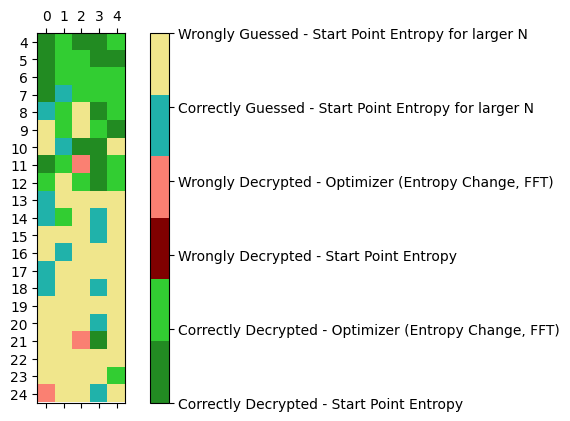

In [12]:
evaluate_decryption(decrypt_1)

In [17]:
def failure_analysis(keylen, correct):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))

    ciphertext = ciphers[keylen][correct]
    anom = detect_start_entropy_anomaly(ciphertext, ax=axes[0])
    if anom >= 0:
        print("start anomaly worked out!")
        return
    print("start anomaly didn't work!:", anom)
    plain_stream = encode(plains[correct][:30])

    for pi, plaintext in enumerate(plains):
        candids = select_first_local_minimum_removal(ciphertext, plaintext)
        l, remove_i = search_fft_fit(ciphertext, plaintext, candids)
        print(f'{pi}: candids {candids} -> {(l, remove_i)}', list(candids))

        # optimization succeded
        if l != -1:
            new_cipher = cipher_removed_at(ciphertext, remove_i)
            diffs = stream_diff(encode(new_cipher[:30]), plain_stream)
            print('ent', entropy(diffs))

            argmin = detect_start_entropy_anomaly(new_cipher, N=30, pick_min=True)
            print(argmin)
            break
    
    print("optimizing ciphertext didn't work out!")
    print("probably the ciphertext has no random character at the head part, or")
    print("more than one random character at the head part")

    print_list(range(30))
    print_list(encode(ciphertext[:30]))
    print_list(plain_stream)
    print_list(stream_diff(encode(ciphertext[:30]), plain_stream))

start anomaly didn't work!: -1
0: candids range(0, 2) -> (-1, None) [0, 1]
1: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
2: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
3: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
4: candids range(0, 5) -> (-1, None) [0, 1, 2, 3, 4]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
08 21 03 20 08 18 08 14 12 04 01 25 12 07 16 11 25 23 16 20 14 04 20 24 16 05 15 22 04 24 
20 18 05 14 03 08 05 04 00 23 09 03 11 05 18 23 15 18 11 00 15 18 09 05 14 20 01 20 09 15 
15 03 25 06 05 10 03 10 12 08 19 22 01 02 25 15 10 05 05 20 26 13 11 19 02 12 14 02 22 09 


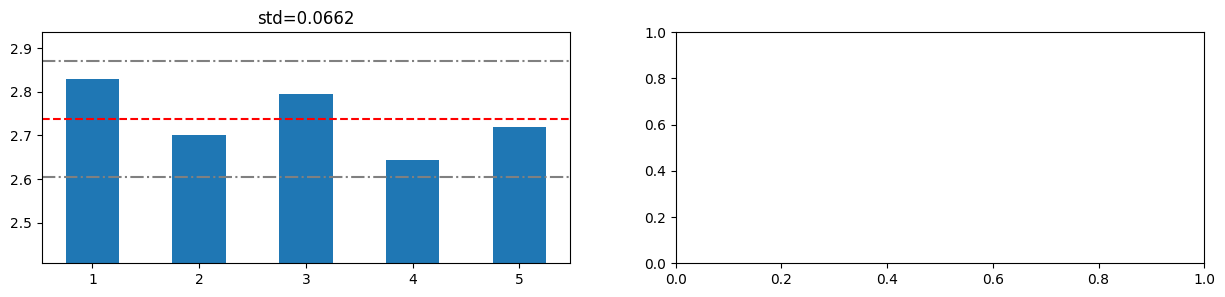

In [18]:
# two random characters at the head part at index 0 and 2
failure_analysis(8, 2)

In [ ]:
def plot_optimizer_behavior(ciphertext, plaintext, search_space=30, correct=None):
    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)

    ents = []
    de_list = []
    start_ent = entropy(diffs)
    prev_ent = start_ent

    first_new_ciphertext = ciphertext[1:][:search_space]
    first_new_cipher_stream = encode(first_new_ciphertext)
    diffs = stream_diff(first_new_cipher_stream, plain_stream)
    first_ent = entropy(diffs)

    allow_increasing = first_ent > start_ent * 1.05

    ci = 0
    while ci < search_space:
        new_ciphertext = cipher_removed_at(ciphertext, ci)
        new_cipher_stream = encode(new_ciphertext[:search_space])
        diffs = stream_diff(new_cipher_stream, plain_stream)
        ent = entropy(diffs)

        ents.append(ent)
        de = (ent - prev_ent) / prev_ent * 100
        de_list.append(de)

        if de > 1.2 and not allow_increasing:
            print(ci, end=' ')
        if de < 0:
            allow_increasing = False

        ci += 1
        prev_ent = ent
    
    print()
    
    # plt.plot(range(search_space), de_list, c='red')
    plt.ylim(np.min(ents) - 0.05, np.max(ents) + 0.05)
    plt.bar(range(-1, search_space), [start_ent] + ents, width=0.5)
    plt.plot(range(search_space), ents)
    plt.axhline(0, linestyle='--', color='gray')

    min_ent_i = np.argmin(ents)
    if correct:
        plt.scatter(correct, ents[correct], marker='s', c='r')
    plt.scatter(min_ent_i, ents[min_ent_i], c='m', marker='x')

    for ci, de in enumerate(de_list):
        if de > 0:
            plt.scatter(ci - 1, ents[ci - 1], marker='x', c='red')
            plt.annotate(f'{de:.2f}', (ci - 1, ents[ci - 1] + 0.05))
    

start anomaly didn't work!: -1
0: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
1: candids range(0, 3) -> (-1, None) [0, 1, 2]
2: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
3: candids range(7, 12) -> (-1, None) [7, 8, 9, 10, 11]
4: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
03 03 21 17 14 13 11 26 09 01 00 09 03 22 24 10 25 07 02 21 00 16 02 06 08 23 05 12 12 03 
02 01 18 13 09 05 19 20 00 08 01 19 20 05 19 00 19 16 01 04 05 19 00 06 05 22 05 18 19 00 
01 02 03 04 05 08 19 06 09 20 26 17 10 17 05 10 06 18 01 17 22 24 02 00 03 01 00 21 20 03 
0 9 11 12 21 22 24 


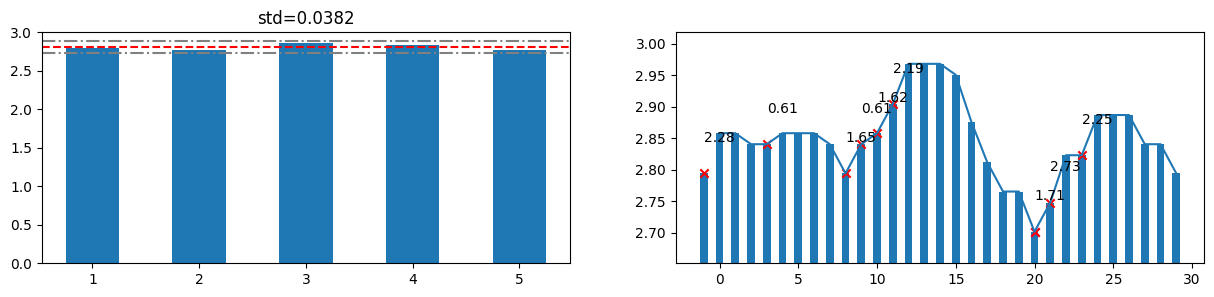

In [269]:
# two random characters at the head part at index 5 and ?
failure_analysis(9, 0)
plot_optimizer_behavior(ciphers[9][0], plains[0], 30)

start anomaly didn't work!: -1
0: candids range(10, 15) -> (-1, None) [10, 11, 12, 13, 14]
1: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
2: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
3: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
4: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
21 20 08 18 08 14 12 12 05 00 24 11 06 15 10 05 24 03 23 18 12 02 18 19 22 14 00 11 21 01 
20 18 05 14 03 08 05 04 00 23 09 03 11 05 18 23 15 18 11 00 15 18 09 05 14 20 01 20 09 15 
01 02 03 04 05 06 07 08 05 04 15 08 22 10 19 09 09 12 12 18 24 11 09 14 08 21 26 18 12 13 
6 8 13 16 26 


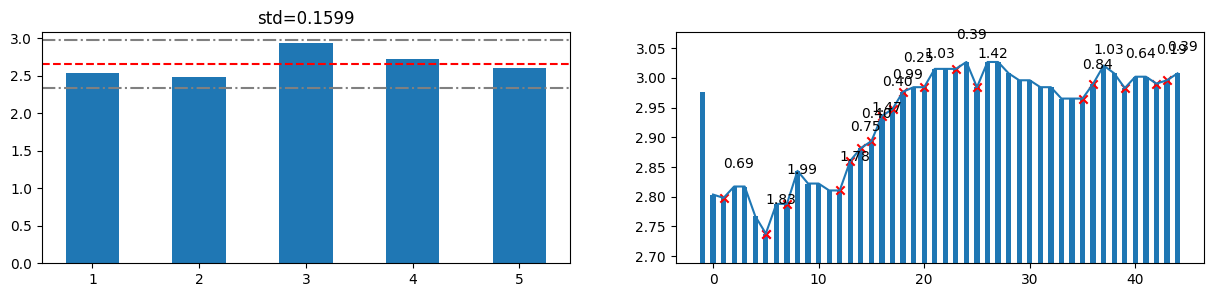

In [291]:
# optimization failed to find the random character correctly (correct=08)
failure_analysis(9, 2)
plot_optimizer_behavior(ciphers[9][2], plains[2], 45)

start anomaly didn't work!: -1
0: candids range(8, 13) -> (-1, None) [8, 9, 10, 11, 12]
1: candids range(0, 1) -> (-1, None) [0]
2: candids range(0, 1) -> (-1, None) [0]
3: candids range(0, 2) -> (-1, None) [0, 1]
4: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
09 04 04 22 18 15 12 00 02 10 09 03 22 24 10 25 07 00 25 11 17 05 06 07 22 12 04 11 11 02 
02 01 18 13 09 05 19 20 00 08 01 19 20 05 19 00 19 16 01 04 05 19 00 06 05 22 05 18 19 00 
07 03 13 09 09 10 20 07 02 02 08 11 02 19 18 25 15 11 24 07 12 13 06 01 17 17 26 20 19 02 
12 15 16 17 19 23 25 27 


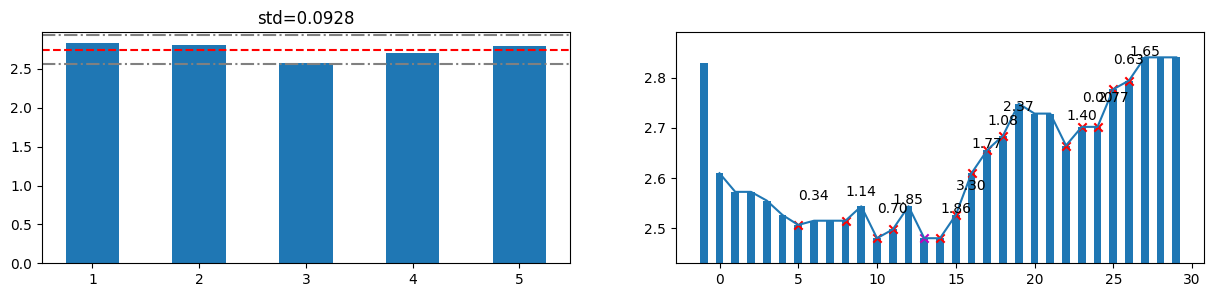

In [292]:
# optimizer failed to guess the random character correctly
failure_analysis(10, 0)
plot_optimizer_behavior(ciphers[10][0], plains[0], 30)

start anomaly didn't work!: -1
0: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
1: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
2: candids range(0, 0) -> (-1, None) []
3: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
4: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
06 08 18 26 20 10 17 10 03 10 17 17 04 08 14 25 23 23 11 25 00 03 13 18 22 12 26 18 22 14 
04 05 14 21 14 03 09 01 20 09 15 14 00 03 08 18 15 14 01 24 25 00 09 13 16 05 18 09 12 13 
02 03 04 05 06 07 08 09 10 01 02 03 04 05 06 07 08 09 10 01 02 03 04 05 06 07 08 09 10 01 


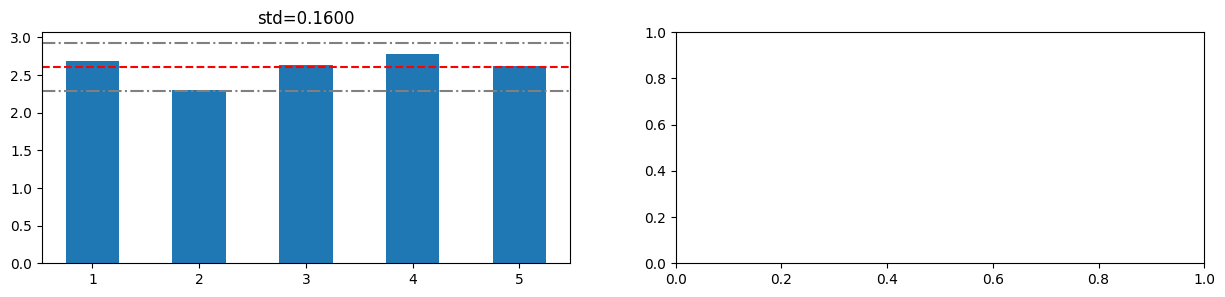

In [293]:
# no random character at the head part
# the start entropy test failed due to the long key length
failure_analysis(10, 1)

start anomaly didn't work!: -1
0: candids range(4, 9) -> (-1, None) [4, 5, 6, 7, 8]
1: candids range(0, 3) -> (-1, None) [0, 1, 2]
2: candids range(0, 2) -> (-1, None) [0, 1]
3: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
4: candids range(0, 3) -> (-1, None) [0, 1, 2]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
21 06 12 18 11 12 26 18 24 08 02 12 18 24 10 26 16 01 03 03 16 20 24 03 12 06 15 25 20 24 
19 03 08 13 05 05 18 09 14 07 00 09 14 19 20 09 20 21 20 15 18 00 08 01 09 18 12 15 03 11 
02 03 04 05 06 07 08 09 10 01 02 03 04 05 17 17 23 07 10 15 25 20 16 02 03 15 03 10 17 13 
0 2 3 15 17 20 21 22 


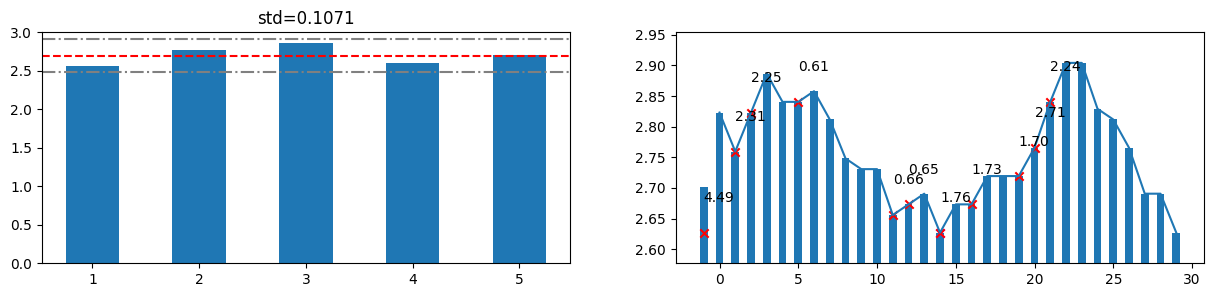

In [264]:
# optimizer failed to guess the random character correctly (correct=14)
failure_analysis(10, 4)
plot_optimizer_behavior(ciphers[10][4], plains[4], 30)

start anomaly didn't work!: -1
0: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
1: candids range(0, 2) -> (-1, None) [0, 1]
2: candids range(3, 8) -> (-1, None) [3, 4, 5, 6, 7]
3: candids range(0, 3) -> (-1, None) [0, 1, 2]
4: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
06 13 00 18 21 15 22 10 05 05 26 14 26 18 02 16 11 21 15 22 06 02 01 04 23 05 20 17 18 13 
04 05 14 21 14 03 09 01 20 09 15 14 00 03 08 18 15 14 01 24 25 00 09 13 16 05 18 09 12 13 
02 08 13 24 07 12 13 09 12 23 11 00 26 15 21 25 23 07 14 25 08 02 19 18 07 00 02 08 06 00 
1 3 5 11 12 19 


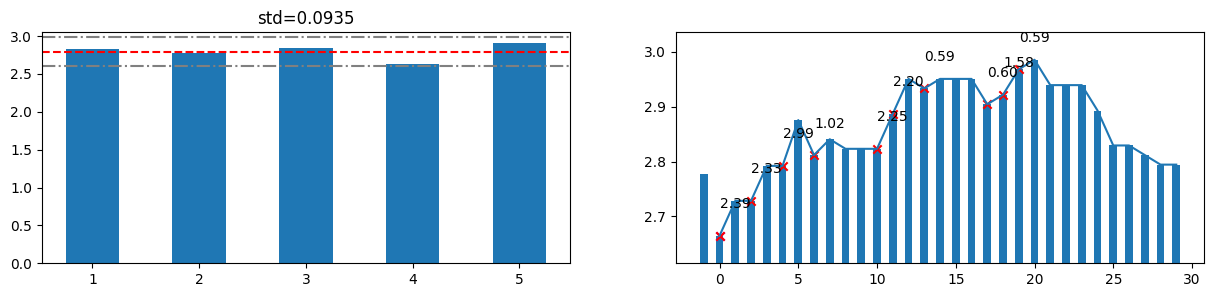

In [266]:
failure_analysis(12, 1)
plot_optimizer_behavior(ciphers[12][1], plains[1], 30)

range(0, 4)
-1 None


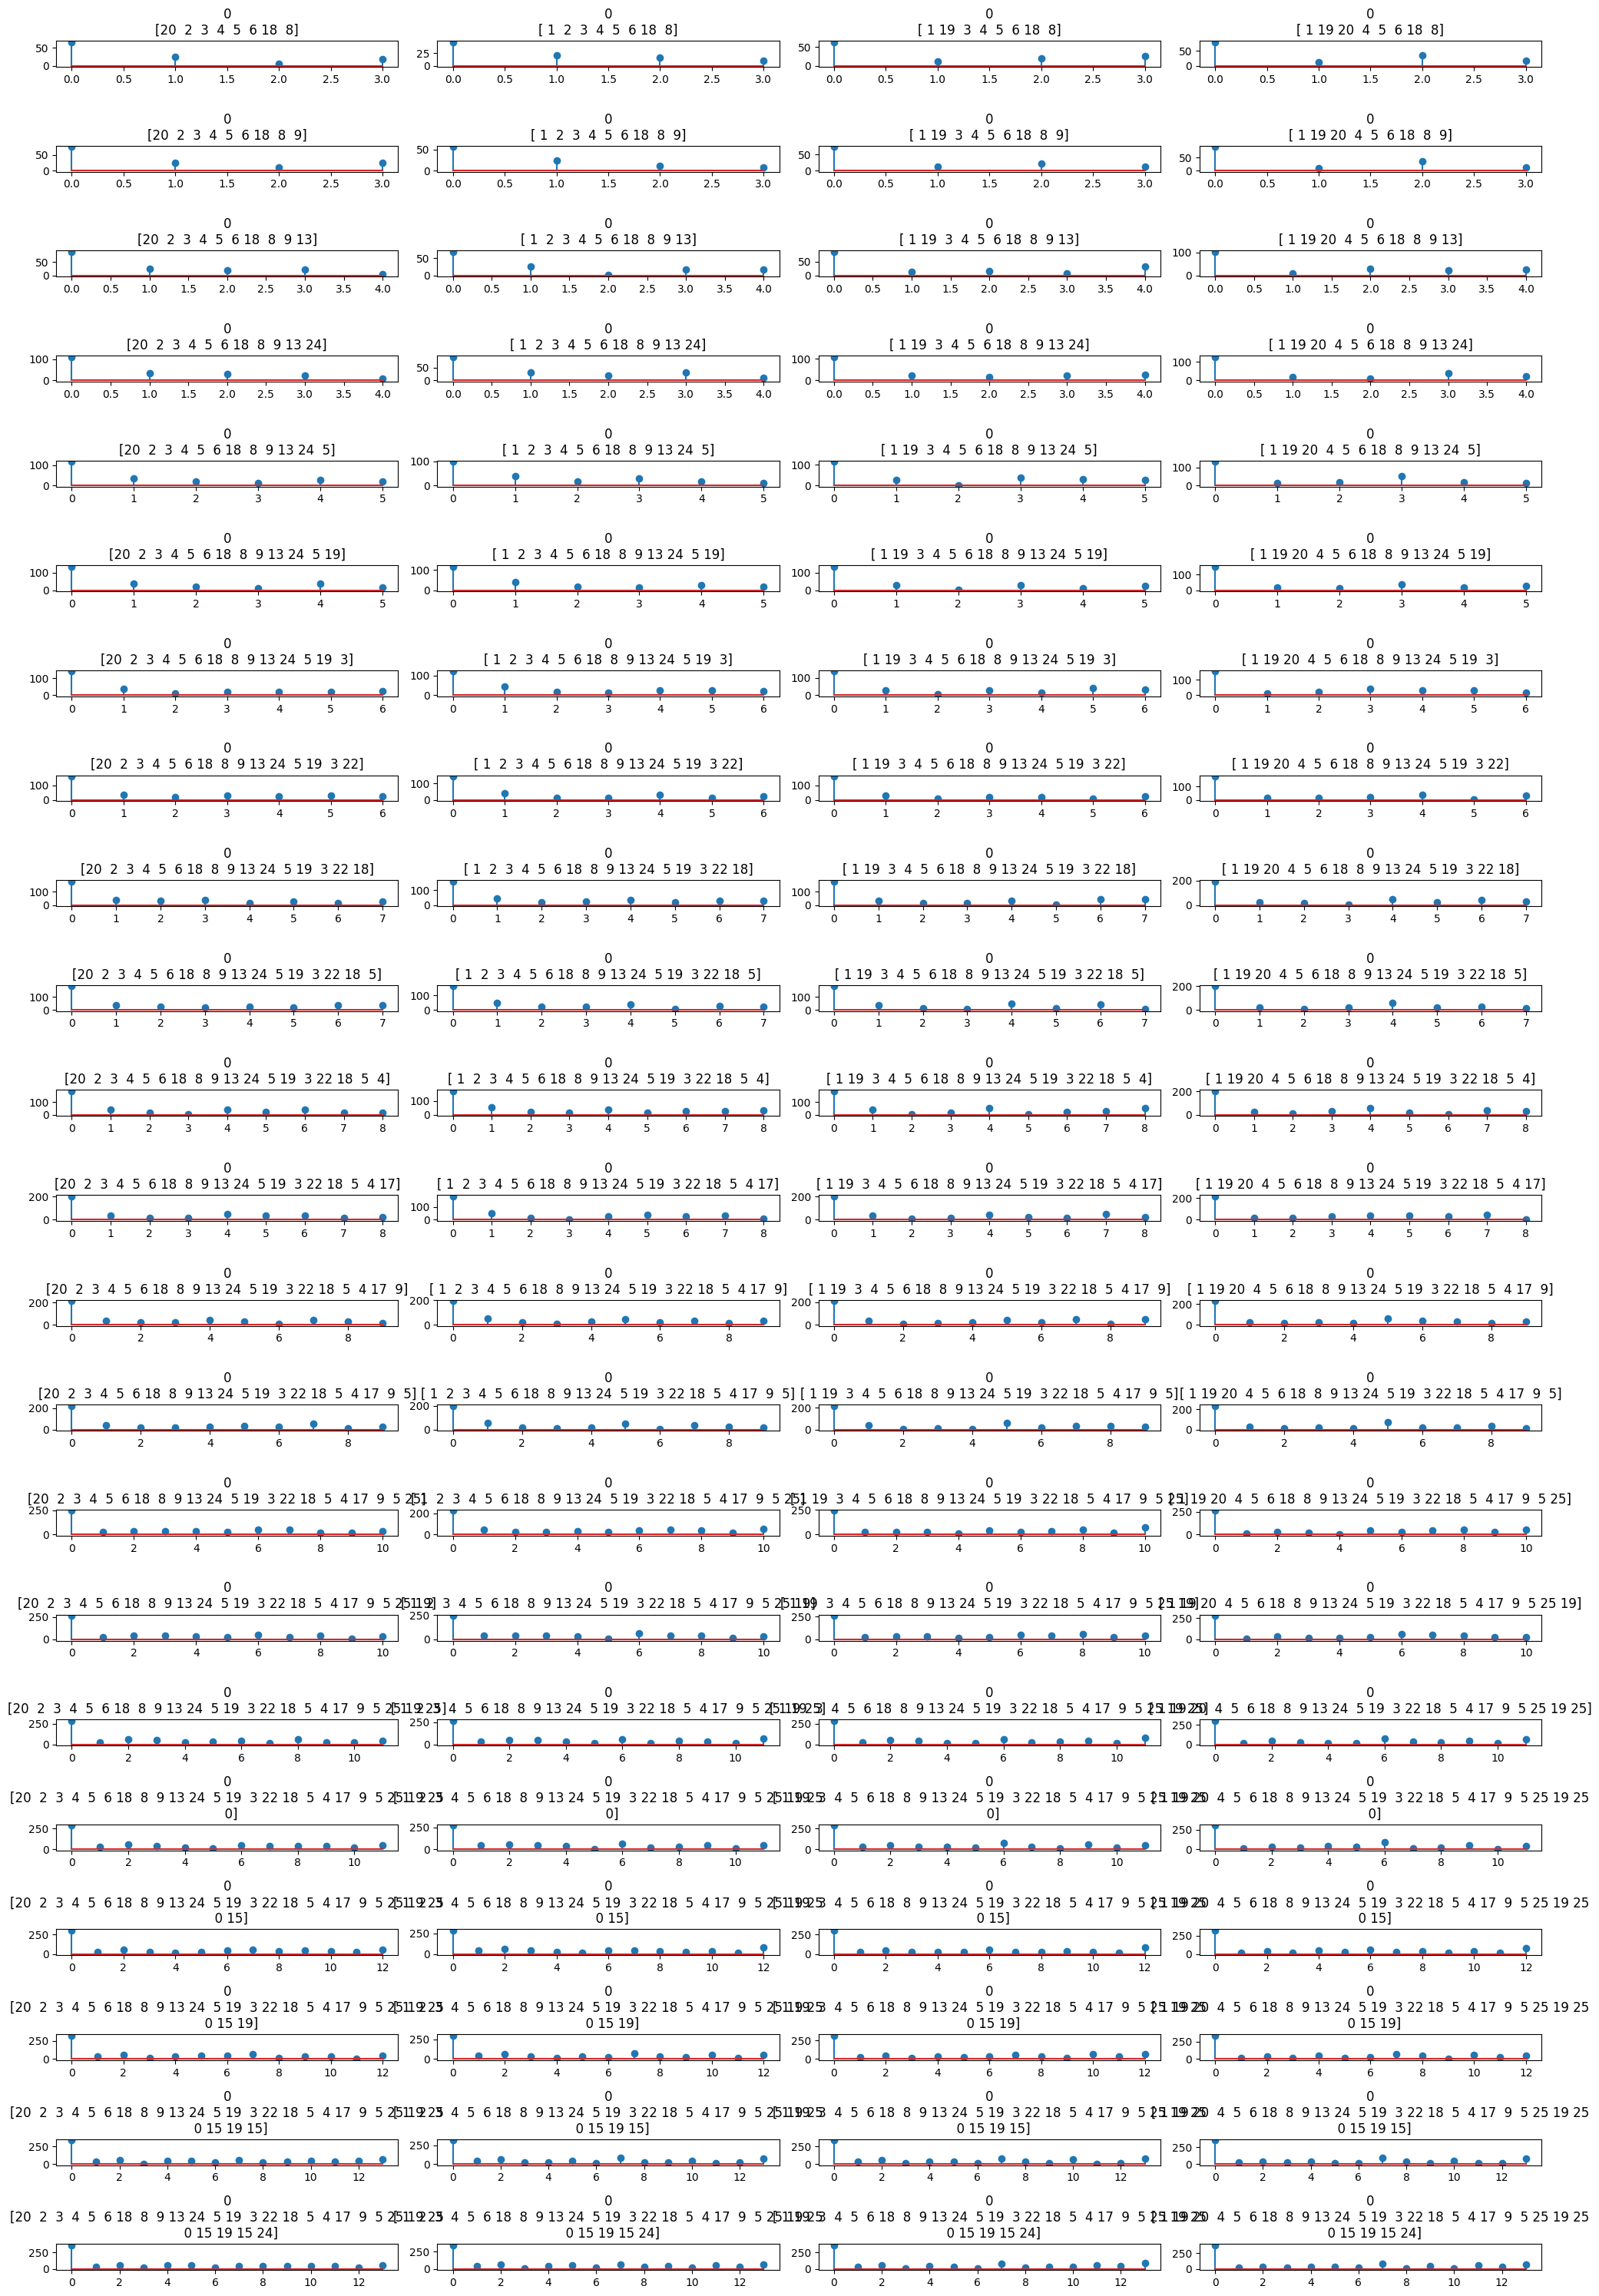

In [313]:
# We know removing a character would be not enough
# if FFT failed

removal_candids = select_first_local_minimum_removal(ciphers[7][1], plains[1])
print(removal_candids)

fig, axes = plt.subplots(22, len(removal_candids), figsize=(20, 30))
l, i =search_fft_fit(ciphers[7][1], plains[1], removal_candids, axes=axes)
fig.tight_layout()
print(l, i)

8 16 18 19 24 25 26 29 


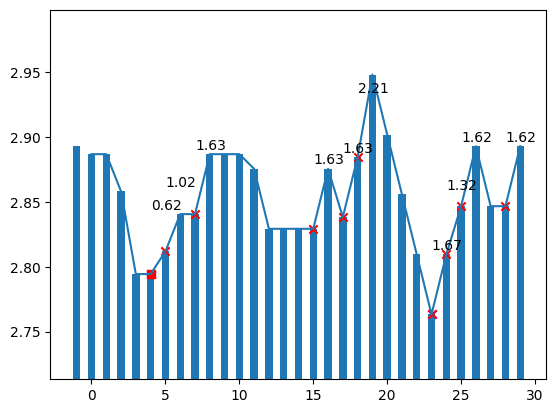

In [186]:
plot_optimizer_behavior(ciphers[4][1], plains[1], correct=4)

2 4 11 13 18 21 23 25 


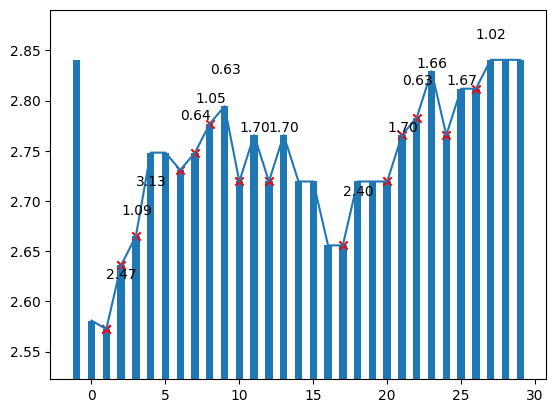

In [187]:
plot_optimizer_behavior(ciphers[4][4], plains[4], correct=0)

6 7 8 10 11 15 16 17 19 26 29 


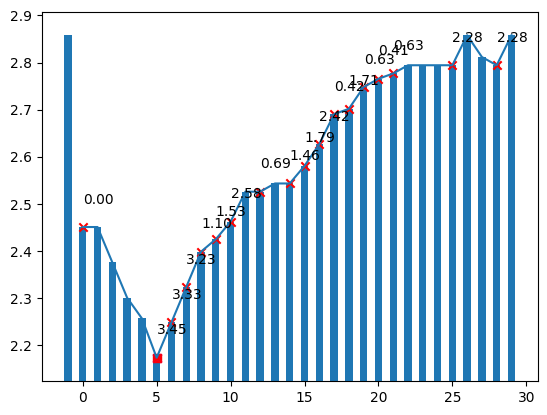

In [311]:
plot_optimizer_behavior(ciphers[5][1], plains[1], correct=5)

19
25
26


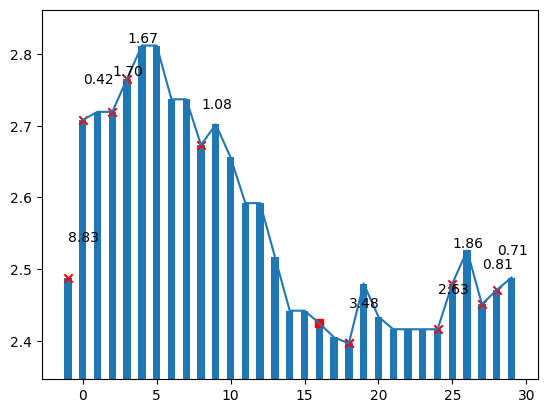

In [121]:
plot_optimizer_behavior(ciphers[6][2], plains[2], correct=16)

25 26 27 28 29 


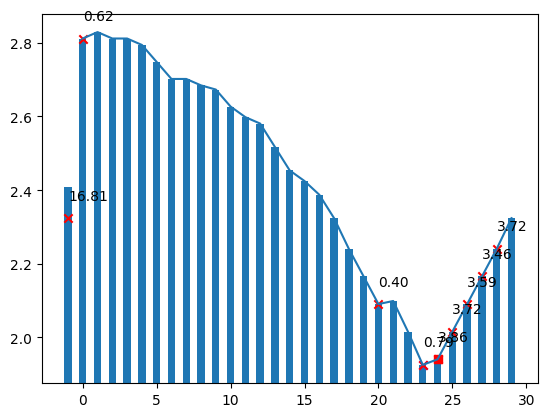

In [312]:
plot_optimizer_behavior(ciphers[7][2], plains[2], correct=24)

In [106]:
def fft_analysis(ciphertext, plaintext, search_space=30, debug=False):
    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)

    freqs = np.fft.fft(diffs)
    magnitudes = np.abs(freqs)
    magnitudes = magnitudes[:len(magnitudes)//2]
    peaks, _ = sp.signal.find_peaks(magnitudes)
    mag_mean = np.mean(magnitudes)
    mag_std = np.std(magnitudes)

    plt.stem(magnitudes)  # Plot only positive frequencies
    plt.plot(peaks, magnitudes[peaks], 'x', c='red')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('FFT of Data')
    plt.axhline(mag_mean, linestyle='--', color='red')
    plt.axhline(mag_mean + mag_std, linestyle='--', color='gray')
    plt.show()

    if debug:
        print(diffs)
        print(magnitudes)
        # Print the computed FFT values
        print("FFT values:")
        for i, value in enumerate(freqs):
            print(f"Frequency {i}: {value}")
        
        # Print magnitudes
        print(f"\nMagnitudes:")
        for i, mag in enumerate(magnitudes):
            print(f"Frequency {i}: {mag:.2f}")

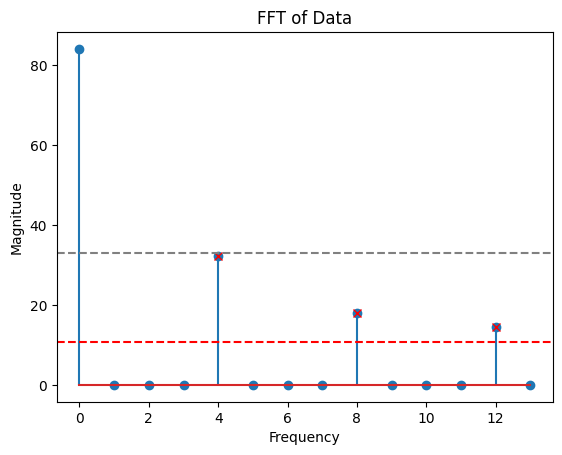

In [107]:
fft_analysis(ciphers[7][0], plains[0], search_space=28)